## How to map your Google location history with R
Source: https://shiring.github.io/maps/2016/12/30/Standortverlauf_post

### Loading the Data

In [1]:
library(jsonlite)

Warning message:
"package 'jsonlite' was built under R version 3.3.2"

In [2]:
# how long did it take to load the data in R (depends on the data size)
system.time(x <- fromJSON("LocationHistory.json"))

   user  system elapsed 
  26.52    0.15   27.25 

In [3]:
# extracting the locations dataframe
loc = x$locations

# converting time column from posix milliseconds into a readable time scale
loc$time = as.POSIXct(as.numeric(x$locations$timestampMs)/1000, origin = "1970-01-01")

# converting longitude and latitude from E7 to GPS coordinates
loc$lat = loc$latitudeE7 / 1e7
loc$lon = loc$longitudeE7 / 1e7

In [4]:
head(loc)

timestampMs,latitudeE7,longitudeE7,accuracy,activitys,heading,velocity,altitude,time,lat,lon
1483746895704,357712102,-786908820,20,NULL,NA,NA,NA,2017-01-06 18:54:55,35.77121,-78.69088
1483746513457,357712102,-786908820,21,NULL,NA,NA,NA,2017-01-06 18:48:33,35.77121,-78.69088
1483746153243,357712102,-786908820,21,NULL,NA,NA,NA,2017-01-06 18:42:33,35.77121,-78.69088
1483745851974,357712102,-786908820,20,NULL,NA,NA,NA,2017-01-06 18:37:31,35.77121,-78.69088
1483745792464,357712102,-786908820,20,NULL,NA,NA,NA,2017-01-06 18:36:32,35.77121,-78.69088
1483745429487,357712102,-786908820,20,NULL,NA,NA,NA,2017-01-06 18:30:29,35.77121,-78.69088


-----------------------------

### Data Stats

In [5]:
# how many rows are in the data frame?
nrow(loc)

[1] 135499

In [6]:
# first entry, last entry
min(loc$time)
max(loc$time)

[1] "2015-11-17 10:28:34 EST"

[1] "2017-01-06 18:54:55 EST"

In [7]:
# calculate the number of data points per day, month and year
library(lubridate)
library(zoo)

loc$date <- as.Date(loc$time, '%Y/%m/%d')
loc$year <- year(loc$date)
loc$month_year <- as.yearmon(loc$date)

points_p_day <- data.frame(table(loc$date), group = "day")
points_p_month <- data.frame(table(loc$month_year), group = "month")
points_p_year <- data.frame(table(loc$year), group = "year")

Warning message:
"package 'lubridate' was built under R version 3.3.2"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'zoo' was built under R version 3.3.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message in as.POSIXlt.POSIXct(x, tz = tz):
"unknown timezone '%Y/%m/%d'"

In [8]:
# number of days recorded
nrow(points_p_day)
# number of months recorded
nrow(points_p_month)
# number of years recorded
nrow(points_p_year)

[1] 406

[1] 15

[1] 3

In [9]:
# set up plotting theme
library(ggplot2)
library(ggmap)

my_theme <- function(base_size = 12, base_family = "sans"){
  theme_grey(base_size = base_size, base_family = base_family) +
  theme(
    axis.text = element_text(size = 12),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    axis.title = element_text(size = 14),
    panel.grid.major = element_line(color = "grey"),
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "aliceblue"),
    strip.background = element_rect(fill = "lightgrey", color = "grey", size = 1),
    strip.text = element_text(face = "bold", size = 12, color = "navy"),
    legend.position = "right",
    legend.background = element_blank(),
    panel.margin = unit(.5, "lines"),
    panel.border = element_rect(color = "grey", fill = NA, size = 0.5)
  )
}

Warning message:
"package 'ggplot2' was built under R version 3.3.2"Warning message:
"package 'ggmap' was built under R version 3.3.2"

Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

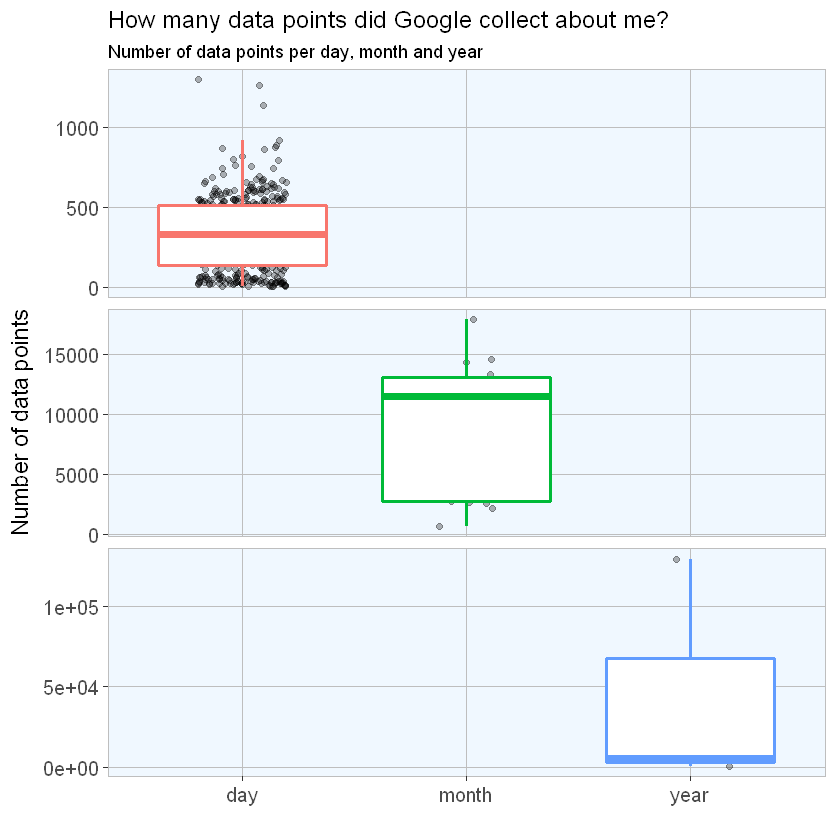

In [10]:
points <- rbind(points_p_day[, -1], points_p_month[, -1], points_p_year[, -1])

ggplot(points, aes(x = group, y = Freq)) + 
  geom_point(position = position_jitter(width = 0.2), alpha = 0.3) + 
  geom_boxplot(aes(color = group), size = 1, outlier.colour = NA) + 
  facet_grid(group ~ ., scales = "free") + my_theme() +
  theme(
    legend.position = "none",
    strip.placement = "outside",
    strip.background = element_blank(),
    strip.text = element_blank(),
    axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 0.5)
  ) +
  labs(
    x = "",
    y = "Number of data points",
    title = "How many data points did Google collect about me?",
    subtitle = "Number of data points per day, month and year"
  )

----------------------------

### Plotting the data on maps

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=United+States&zoom=4&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=United%20States&sensor=false


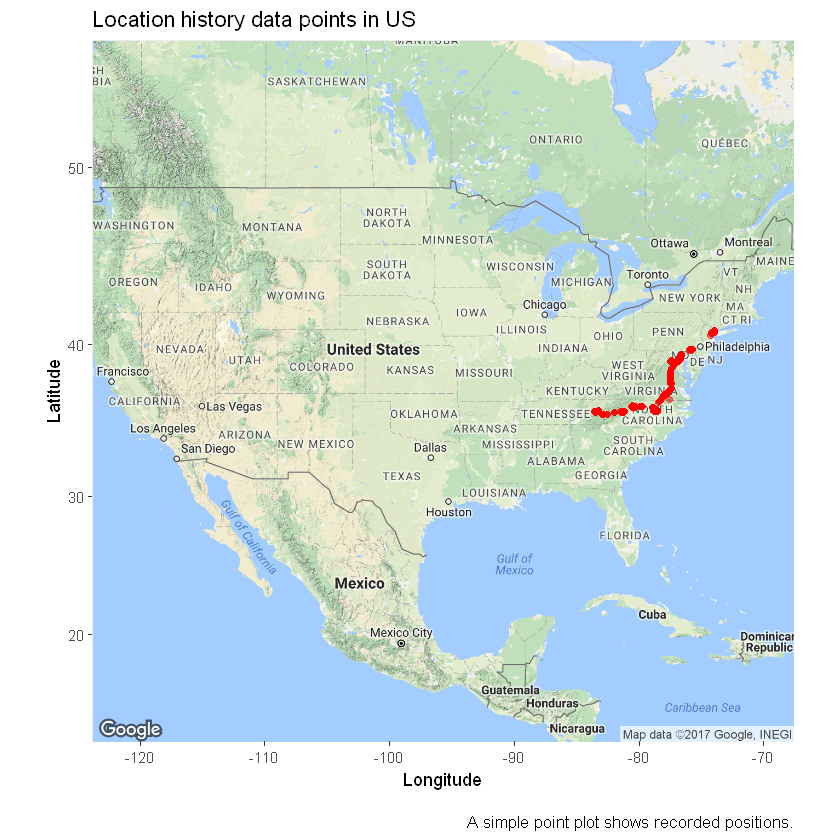

In [11]:
usa <- get_map(location = 'United States', zoom = 4)

ggmap(usa) + geom_point(data = loc, aes(x = lon, y = lat), alpha = 0.5, color = "red") + 
  theme(legend.position = "right") + 
  labs(
    x = "Longitude", 
    y = "Latitude", 
    title = "Location history data points in US",
    caption = "\nA simple point plot shows recorded positions.")

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Raleigh&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Raleigh&sensor=false
Warning message:
"Removed 4510 rows containing non-finite values (stat_summary2d)."

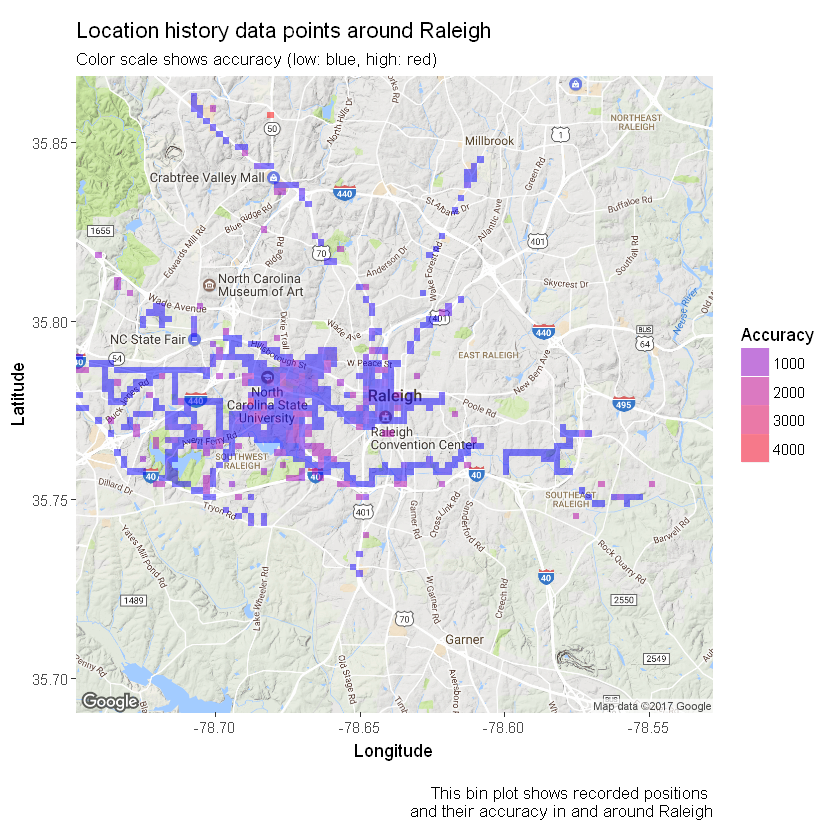

In [12]:
raleigh <- get_map(location = 'Raleigh', zoom = 12)

options(stringsAsFactors = T)
ggmap(raleigh) + 
  stat_summary_2d(geom = "tile", bins = 100, data = loc, aes(x = lon, y = lat, z = accuracy), alpha = 0.5) + 
  scale_fill_gradient(low = "blue", high = "red", guide = guide_legend(title = "Accuracy")) +
  labs(
    x = "Longitude", 
    y = "Latitude", 
    title = "Location history data points around Raleigh",
    subtitle = "Color scale shows accuracy (low: blue, high: red)",
    caption = "\nThis bin plot shows recorded positions 
    and their accuracy in and around Raleigh")

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Raleigh&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Raleigh&sensor=false
Warning message:
"Removed 2076 rows containing missing values (geom_point)."

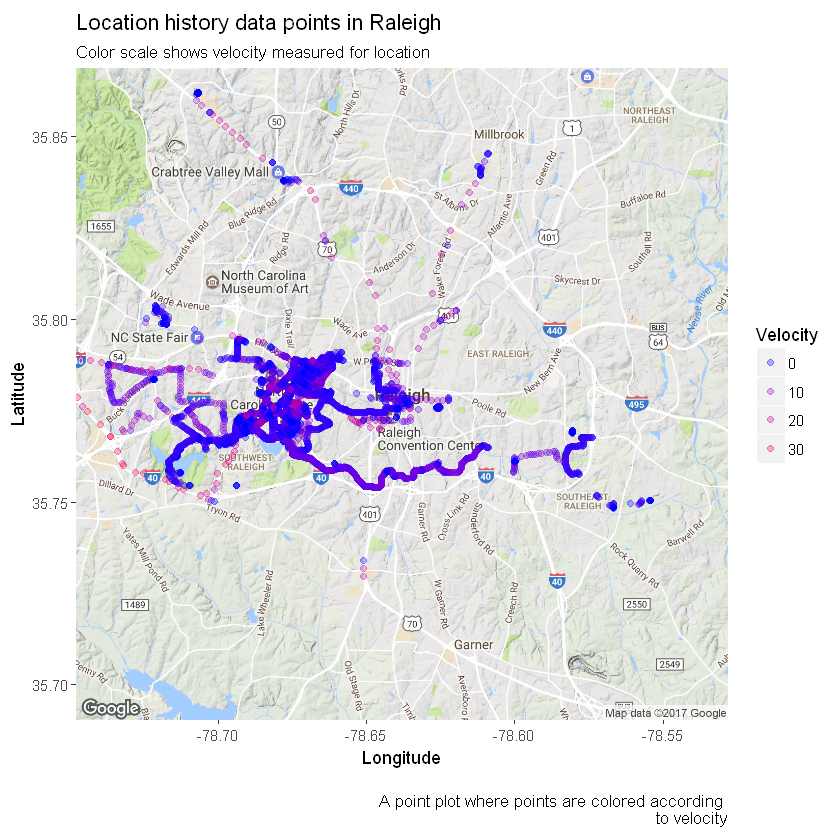

In [13]:
loc_2 <- loc[which(!is.na(loc$velocity)), ]

raleigh_vel <- get_map(location = 'Raleigh', zoom = 12)

ggmap(raleigh_vel) + geom_point(data = loc_2, aes(x = lon, y = lat, color = velocity), alpha = 0.3) + 
  theme(legend.position = "right") + 
  labs(x = "Longitude", y = "Latitude", 
       title = "Location history data points in Raleigh",
       subtitle = "Color scale shows velocity measured for location",
       caption = "\nA point plot where points are colored according 
       to velocity") +
  scale_colour_gradient(low = "blue", high = "red", guide = guide_legend(title = "Velocity"))

In [ ]:
loc3 <- with(loc, subset(loc, loc$time > as.POSIXct('2016-12-01 0:00:01')))
loc3 <- with(loc, subset(loc3, loc$time < as.POSIXct('2016-12-31 23:59:59')))

# Shifting vectors for latitude and longitude to include end position
shift.vec <- function(vec, shift){
  if (length(vec) <= abs(shift)){
    rep(NA ,length(vec))
  } else {
    if (shift >= 0) {
      c(rep(NA, shift), vec[1:(length(vec) - shift)]) }
    else {
      c(vec[(abs(shift) + 1):length(vec)], rep(NA, abs(shift)))
    }
  }
}

loc3$lat.p1 <- shift.vec(loc3$lat, -1)
loc3$lon.p1 <- shift.vec(loc3$lon, -1)

# Calculating distances between points (in metres) with the function pointDistance from the 'raster' package.
library(raster)
loc3$dist.to.prev <- apply(loc3, 1, FUN = function(row) {
  pointDistance(c(as.numeric(as.character(row["lat.p1"])),
                  as.numeric(as.character(row["lon.p1"]))),
                c(as.numeric(as.character(row["lat"])), as.numeric(as.character(row["lon"]))),
                lonlat = T) # Parameter 'lonlat' has to be TRUE!
})

In [ ]:
# distance in km
round(sum(as.numeric(as.character(loc3$dist.to.prev)), na.rm = TRUE)*0.001, digits = 2)

In [ ]:
distance_p_month <- aggregate(loc3$dist.to.prev, by = list(month_year = as.factor(loc3$month_year)), FUN = sum)
distance_p_month$x <- distance_p_month$x*0.001

In [ ]:
ggplot(distance_p_month[-1, ], aes(x = month_year, y = x,  fill = month_year)) + 
  geom_bar(stat = "identity")  + 
  guides(fill = FALSE) +
  my_theme() +
  labs(
    x = "",
    y = "Distance in km",
    title = "Distance traveled per month in second half of 2016",
    caption = "This barplot shows the sum of distances between recorded 
    positions for 2016."
  )

In [ ]:
library(dplyr)
head(arrange(points_p_month,desc(Freq)))

# Use year as grouping variable to see where you were the different years. Also, notice the very cool maptype used here, black/white, great for focusing the attention to your plotted points:
loc$year <- as.factor(loc$year)
us_year <- get_map(location = 'United States', zoom = 4)#,source="stamen",maptype="toner") 
ggmap(us_year) + geom_point(data = loc, aes(x = lon, y = lat,fill=year,color=year), alpha = 0.5,size=.75) + 
scale_color_manual(values=c("blue", "red", "orange"))

Var1,Freq,group
Jul 2016,17947,month
May 2016,14608,month
Jun 2016,14387,month
Apr 2016,13365,month
Jan 2016,12759,month
Oct 2016,12035,month


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=United+States&zoom=4&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=United%20States&sensor=false
